In [ ]:
!pip -q install transformers datasets evaluate accelerate sentencepiece rouge_score sacrebleu matplotlib pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from tqdm.auto import tqdm
from datasets import load_dataset
import transformers, datasets, evaluate, accelerate
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    set_seed,
)

SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("accelerate:", accelerate.__version__)

os.makedirs("results", exist_ok=True)
os.makedirs("saved_model", exist_ok=True)

rouge = evaluate.load("rouge")

GPU available: True
Device: Tesla T4
transformers: 4.57.3
datasets: 4.0.0
evaluate: 0.4.6
accelerate: 1.12.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

TRAIN_SAMPLES = 20000
VAL_SAMPLES   = 2000
TEST_SAMPLES  = 2000

train_ds = dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SAMPLES))
val_ds   = dataset["validation"].shuffle(seed=SEED).select(range(VAL_SAMPLES))
test_ds  = dataset["test"].shuffle(seed=SEED).select(range(TEST_SAMPLES))

train_ds, val_ds, test_ds

README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

(Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 20000
 }),
 Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 2000
 }),
 Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 2000
 }))

In [ ]:
MODEL_NAME = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

MAX_INPUT_LEN = 512
MAX_TARGET_LEN = 128

def preprocess(batch):
    inputs = ["summarize: " + x for x in batch["article"]]
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LEN,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["highlights"],
            max_length=MAX_TARGET_LEN,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]

    model_inputs["labels"] = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label_ids]
        for label_ids in model_inputs["labels"]
    ]
    return model_inputs

tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
tokenized_val   = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)
tokenized_test  = test_ds.map(preprocess, batched=True, remove_columns=test_ds.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
BATCH_SIZE = 4
EPOCHS = 1

training_args = Seq2SeqTrainingArguments(
    output_dir="t5_cnn_dm_runs",
    eval_strategy="no",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    num_train_epochs=EPOCHS,
    predict_with_generate=False,
    fp16=False,
    report_to="none",
    seed=SEED
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator
)

experiment_config = {
    "model": MODEL_NAME,
    "seed": SEED,
    "train_samples": TRAIN_SAMPLES,
    "val_samples": VAL_SAMPLES,
    "test_samples_total": TEST_SAMPLES,
    "max_input_len": MAX_INPUT_LEN,
    "max_target_len": MAX_TARGET_LEN,
    "learning_rate": 5e-5,
    "batch_size_train": BATCH_SIZE,
    "epochs": EPOCHS
}

with open("results/experiment_config.json", "w") as f:
    json.dump(experiment_config, f, indent=2)

experiment_config

/tmp/ipython-input-1086504505.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


{'model': 't5-small',
 'seed': 42,
 'train_samples': 20000,
 'val_samples': 2000,
 'test_samples_total': 2000,
 'max_input_len': 512,
 'max_target_len': 128,
 'learning_rate': 5e-05,
 'batch_size_train': 4,
 'epochs': 1}

Step,Training Loss
100,2.264400
200,2.126600
300,2.125000
400,2.079800
500,2.117000
600,2.041100
700,2.127800
800,2.063000
900,2.062400
1000,2.017100


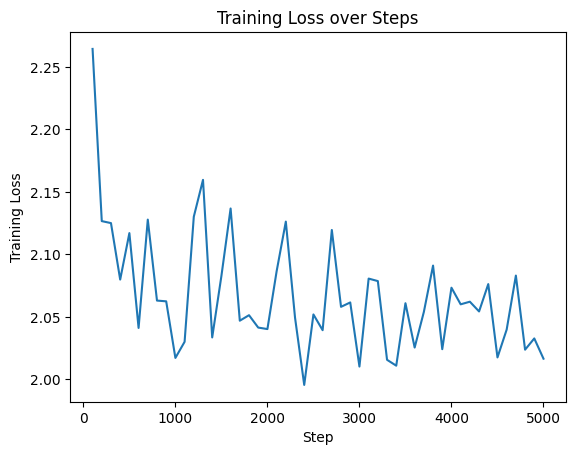

Training done.


In [ ]:
train_result = trainer.train()

logs = trainer.state.log_history
loss_steps = [(x["step"], x["loss"]) for x in logs if "loss" in x]

if loss_steps:
    steps, losses = zip(*loss_steps)
    plt.figure()
    plt.plot(steps, losses)
    plt.xlabel("Step")
    plt.ylabel("Training Loss")
    plt.title("Training Loss over Steps")
    plt.savefig("results/training_loss.png", dpi=200, bbox_inches="tight")
    plt.show()

print("Training done.")

In [ ]:
def rouge_on_dataset_t5(raw_ds, batch_size=2, num_samples=200, num_beams=4):
    preds, refs = [], []
    model.eval()

    for i in tqdm(range(0, num_samples, batch_size)):
        batch = raw_ds[i:i+batch_size]

        inputs = tokenizer(
            ["summarize: " + x for x in batch["article"]],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_INPUT_LEN
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=MAX_TARGET_LEN,
                num_beams=num_beams,
                early_stopping=True
            )

        preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
        refs.extend(batch["highlights"])

        del inputs, outputs
        torch.cuda.empty_cache()

    scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in scores.items()}

EVAL_SAMPLES = 500
GEN_BATCH = 2
NUM_BEAMS = 4

t5_scores = rouge_on_dataset_t5(test_ds, batch_size=GEN_BATCH, num_samples=EVAL_SAMPLES, num_beams=NUM_BEAMS)
t5_scores

  0%|          | 0/250 [00:00<?, ?it/s]

{'rouge1': np.float64(41.18),
 'rouge2': np.float64(18.99),
 'rougeL': np.float64(28.99),
 'rougeLsum': np.float64(35.46)}

In [ ]:
import re

def lead3_summary(text, max_sentences=3):
    sents = re.split(r'(?<=[\.\!\?])\s+', text.strip())
    sents = [s for s in sents if s.strip()]
    return " ".join(sents[:max_sentences])

def rouge_lead3(raw_ds, num_samples=200):
    preds, refs = [], []
    for i in range(num_samples):
        preds.append(lead3_summary(raw_ds[i]["article"], max_sentences=3))
        refs.append(raw_ds[i]["highlights"])

    scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in scores.items()}

lead3_scores = rouge_lead3(test_ds, num_samples=EVAL_SAMPLES)
lead3_scores

{'rouge1': np.float64(40.08),
 'rouge2': np.float64(17.21),
 'rougeL': np.float64(24.66),
 'rougeLsum': np.float64(32.82)}

In [ ]:
comparison = pd.DataFrame([
    {
        "model": "Lead-3 (extractive baseline)",
        "rouge1": lead3_scores.get("rouge1"),
        "rouge2": lead3_scores.get("rouge2"),
        "rougeL": lead3_scores.get("rougeL"),
        "rougeLsum": lead3_scores.get("rougeLsum"),
    },
    {
        "model": "T5-small (abstractive, fine-tuned)",
        "rouge1": t5_scores.get("rouge1"),
        "rouge2": t5_scores.get("rouge2"),
        "rougeL": t5_scores.get("rougeL"),
        "rougeLsum": t5_scores.get("rougeLsum"),
    }
])

comparison.to_csv("results/rouge_comparison_200.csv", index=False)

with open("results/rouge_comparison_200.json", "w") as f:
    json.dump(comparison.to_dict(orient="records"), f, indent=2)

comparison

,model,rouge1,rouge2,rougeL,rougeLsum
0,Lead-3 (extractive baseline),40.08,17.21,24.66,32.82
1,"T5-small (abstractive, fine-tuned)",41.18,18.99,28.99,35.46


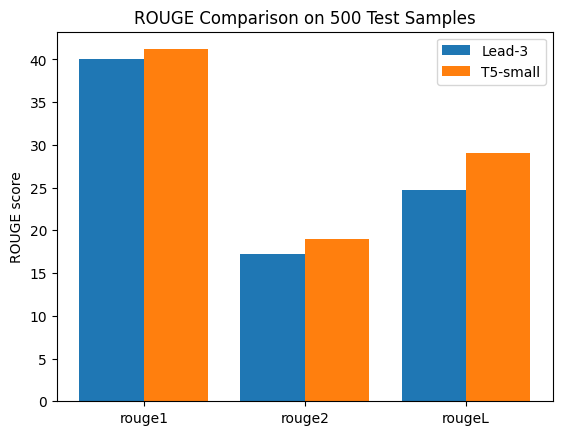

In [ ]:
metrics = ["rouge1", "rouge2", "rougeL"]
x = range(len(metrics))

plt.figure()
plt.bar([i - 0.2 for i in x], comparison.loc[0, metrics], width=0.4, label="Lead-3")
plt.bar([i + 0.2 for i in x], comparison.loc[1, metrics], width=0.4, label="T5-small")
plt.xticks(list(x), metrics)
plt.ylabel("ROUGE score")
plt.title(f"ROUGE Comparison on {EVAL_SAMPLES} Test Samples")
plt.legend()
plt.savefig("results/rouge_comparison_200.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
trainer.save_model("saved_model")
tokenizer.save_pretrained("saved_model")

model.eval()

sample_n = 3
raw_samples = test_ds.select(range(sample_n))

for i in range(sample_n):
    article = raw_samples[i]["article"]
    ref = raw_samples[i]["highlights"]

    inputs = tokenizer(
        "summarize: " + article,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_INPUT_LEN
    ).to(model.device)

    with torch.no_grad():
        gen_ids = model.generate(
            **inputs,
            max_length=MAX_TARGET_LEN,
            num_beams=NUM_BEAMS,
            early_stopping=True
        )

    pred = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print("=" * 90)
    print(f"Example {i+1}")
    print("\nREFERENCE SUMMARY:\n", ref)
    print("\nMODEL SUMMARY:\n", pred)

    del inputs, gen_ids
    torch.cuda.empty_cache()

Example 1

REFERENCE SUMMARY:
 CNN's Dr. Sanjay Gupta says we should legalize medical marijuana now .
He says he knows how easy it is do nothing "because I did nothing for too long"

MODEL SUMMARY:
 eric liu sees signs of a revolution everywhere. liu sees it in politicians who once preferred to play it safe with this explosive issue. liu sees it in the eyes of sterling scientists, previously reluctant to dip a toe into the stigmatized world.
Example 2

REFERENCE SUMMARY:
 Child has amassed thousands of Twitter followers with 'gang life' photos .
In one video he points gun at camera as adults look on unfazed .
His tweets have prompted backlash with calls for intervention .

MODEL SUMMARY:
 The little boy, from Memphis, Tennessee, poses with guns, cash, and bags of marijuana. He has prompted a wave of critics calling his stunts'sad' In many pictures he laughs and points the gun at the camera.
Example 3

REFERENCE SUMMARY:
 The presidential hopeful held a town hall meeting in Kenilworth o